## Predicting Mini-Protein Stability from Primary Amino Acid Sequences

### Jason Klima (klimaj@uw.edu)



### First, download Additional Data Files S2 and S3 from from Rocklin, Gabriel J. et al.“Global Analysis of Protein Folding Using Massively Parallel Design, Synthesis and Testing.” Science (New York, N.Y.) 357.6347 (2017): 168–175.

### View one or more mini-proteins in py3Dmol

In [1]:
import os
import py3Dmol

In [2]:
path_to_pdb = os.path.expanduser('~/Downloads/aan0693_designed-PDB-files/rd4/EEHEE_rd4_0001.pdb')
structure = open(path_to_pdb, 'r').read()
viewer = py3Dmol.view()
viewer.addModel(structure, 'pdb')
viewer.setStyle({'cartoon':{'color':'spectrum'}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Concatenate datasets into one Pandas dataframe

In [3]:
import glob
import pandas as pd

In [4]:
paths_to_datasets = os.path.expanduser('~/Downloads/aan0693_SI_datasets/stability_scores/rd*_stability_scores')
datasets = pd.concat(map(pd.read_table, glob.glob(paths_to_datasets)), ignore_index=True)
datasets.sample(frac=1).head(10)

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore
96,EEHEE_rd1_0034.pdb,GSVTVEVGGKTFTATSESEAEEIAKRYGATKKTKKGTKFEYRP,1.0,1.87,1.7,2.1,0.4,1.77,0.10,0.05,-0.04,-0.5,0.1,0.6,0.80,-0.84,-0.40,-0.40
52818,PF09145.7_PG_hp,YYDELKKMDAVTVMNVGIDVKGLSEKLDRGIYMEKALEQESSDRGG...,4.0,1.71,1.5,2.0,0.5,1.86,-0.15,-0.07,2.00,1.8,2.2,0.4,1.85,0.15,0.07,-0.07
4006,EHEE_rd1_0208.pdb_hp,GSSEDTIEVSRTNDLDEGKKKAKQQVLEVNEQTRLKRFKGERE,1.0,1.26,0.8,6.6,5.8,0.57,0.69,0.33,0.22,-0.5,1.0,1.5,0.27,-0.05,-0.02,-0.02
44649,HEEH_rd2_0383.pdb,NREAYERLREAYEKGQPVTINGNTFEPGSDEWKRAYEEARKEALES...,4.0,3.96,3.9,4.0,0.1,1.34,2.62,1.25,3.35,3.3,3.5,0.2,0.92,2.44,1.16,1.16
48885,HHH_rd3_0181.pdb,PTEEAKKRIQKAFQNGNEDLAEKLAREANLSEDDLRQLQEEAKLES...,4.0,4.08,4.0,4.2,0.2,0.81,3.26,1.56,3.75,3.5,3.9,0.4,1.14,2.61,1.24,1.24
47576,HEEH_rd4_0828.pdb,DYQDTIETLKEVEKKNQPITLGDIHITSQEQVRRVLESLQRTYLES...,4.0,1.76,1.6,2.0,0.4,1.36,0.40,0.19,2.39,2.3,2.5,0.2,2.43,-0.04,-0.02,-0.02
25032,EEHEE_rd3_0353.pdb_buryD,SEDNINGEQYHFPSLDAAIDWAKKVAEKYNLKYTVKNGKITVK,3.0,3.36,3.4,3.4,0.0,2.17,1.20,0.57,2.35,2.3,2.4,0.1,0.53,1.82,0.87,0.57
48041,HEEH_rd4_0970.pdb,MQVDELVKKVQKEQTTVEIHLNGQTYRVSTEEEVKTFQKKVHSLES...,4.0,0.77,0.5,1.1,0.6,1.56,-0.79,-0.38,0.83,-0.5,2.0,2.5,1.25,-0.42,-0.20,-0.38
54695,chymo_test_Y138,TLHQYTPQGTLHQYTPQGTLHQYTPQGGNNGGGGSGNSGGSSGNNS...,4.0,4.83,4.8,4.9,0.1,4.64,0.19,0.09,3.48,3.4,3.6,0.2,3.25,0.23,0.11,0.09
49407,HHH_rd4_0153.pdb,EEEVERLVERLLRNGVDKRQIEEIVKRQGIDPRKVREVLRKLKLES...,4.0,4.22,4.2,4.3,0.1,-0.27,4.50,2.14,3.38,3.3,3.5,0.2,0.36,3.03,1.44,1.44


### Select, filter, and sort Pandas dataframe

In [5]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

In [6]:
spark = SparkSession.builder.master("local[*]").appName("miniproteins").getOrCreate()
sc = spark.sparkContext
sqlCtx = SQLContext(sc)
sqldf = sqlCtx.createDataFrame(datasets)
df = sqldf.select(sqldf["name"], sqldf["sequence"], sqldf["stabilityscore"]).\
        filter(sqldf["stabilityscore"] != "NaN").\
        sort("stabilityscore", ascending=False)
df.toPandas().head(10)

,name,sequence,stabilityscore
0,HHH_rd2_0058.pdb,DSEQLKEEAKKAYKNGNEEKAKRILKKAGLDESEAEEFLRRAF,2.20
1,HHH_rd2_0022.pdb_buryD,PPELEKIAEELYRRGVSPDQIKEILERLGVNPDLAQEVVDRDV,2.08
2,EEHEE_rd3_1702.pdb,TTIHVGDLTLKYDNPKKAYEIAKKLAKKYNLTVTIKNGKITVT,2.08
3,EHEE_rd4_0009.pdb,GSSSVTYEVDGEEKARRIWKMLAARNLDVKIEIRNGKFILTASLES...,2.05
4,tryp_test_R466,YLWQRIYAEYLWQRIYAEYLWQRIYAESNSNSSNSSNNGSNSSGSG...,2.05
5,HHH_rd2_0139.pdb,DDEARRRAKKLLEKGYSEDYIREYLKRQGVNPDEAEDAIRWAK,2.03
6,EEHEE_rd3_1058.pdb,GTVKVQGITIKVPNPDKAYKIAKKLAKKYNLTVTRKGNTIKVE,2.03
7,HHH_rd2_0158.pdb,PQEEYKKRAKKALKKGDEDTAREALKRAGLSPDQAEEFIRRFLLES...,2.03
8,HHH_rd2_0040.pdb,SDKAREIARELWERGVSPEEIREILEKLGVDSEEAERLAREVK,2.01
9,HHH_rd2_0161.pdb,EEEVKKRIRELAKRGVSPEQIREWLRKQGYSPDQAKQLFEEAM,2.01


### Classify a "stable" mini-protein as having a stabilityscore > 0, and an "unstable" mini-protein as having a stabilityscore <= 0

In [7]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [8]:
def add_protein_stability(data, threshold):
    '''
    Adds a column "foldType" with three major secondary structure class:
    "alpha", "beta", "alpha+beta", and "other" based upon the fraction of alpha/beta content.

    The simplified syntax used in this method relies on two imports:
        from pyspark.sql.functions import when
        from pyspark.sql.functions import col

    Attributes:
        data (Dataset<Row>): input dataset with alpha, beta composition
        minThreshold (float): below this threshold, the secondary structure is ignored
        maxThreshold (float): above this threshold, the secondary structure is ignored
    '''

    return data.withColumn("stability", \
                           when((col("stabilityscore") > threshold), "stable"). \
                           when((col("stabilityscore") <= threshold), "unstable"). \
                           otherwise("other"))

In [9]:
data = add_protein_stability(df, threshold=0.0)
data.toPandas().sample(frac=1).head(10)

,name,sequence,stabilityscore,stability
15574,EEHEE_rd4_0015.pdb_PG_hp_prottest_K36T,VNVKLHGIKITVNEPHHVEHLMEKFYETWKATLNVTGQEFNVELES...,0.25,stable
15998,chymo_test_F155,HEEIFAKHLHEEIFAKHLHEEIFAKHLSGGNNNNGSSSGSNNSSSN...,0.24,stable
30525,EHEE_rd4_0188.pdb_buryD,GSSAFTVTFDGEEQAKKFWQMMVDRNLKAEIRVENGKAVDTVHLES...,-0.07,unstable
24963,EHEE_rd1_0095.pdb,GSSTERYTVQSPEQARKVEENLSKSGREVRTQSDGTTFTVEVR,0.03,stable
3680,2K9D_PG_hp,TAISSFIRDDKMQESSDEYIIRIVKKLKGLNDLLRAKRLVIHLMGS...,1.09,stable
34998,EHEE_rd1_0811.pdb_random,GSSGQRHNEALTTDHVLQETDSHETTFDKQEGYNRVWGWEKKA,-0.16,unstable
55873,EHEE_rd2_0708.pdb_buryD,GSSTTTITVTNPENAERIREEAERRGKDDTVRTHGTTFEVHIK,-1.36,unstable
10215,HEEH_rd2_1273.pdb_buryD,SEEAKKLLEEARNKNTTVTIGNLTVGSSPDAIEDDKRWLKEYE,0.45,stable
4507,HHH_rd1_0117.pdb,PEEAKKFIEKLKREGKSLDEIREIAERNGNREAAELAEKLLRG,0.99,stable
23859,HEEH_rd4_0977.pdb_PG_hp,KINTTVEHILTEGKPVRVDVDGQSVKYEPGRDEAVEEIVEIVRLES...,0.06,stable


### Get maximum and minimum sequence lengths

In [10]:
import numpy as np

In [11]:
lengths = []
for index, row in data.toPandas().iterrows():
    lengths.append(len(row['sequence']))
print('Maximum sequence length = {}\nMinimum sequence length = {}'.format(np.max(lengths), np.min(lengths)))
min_seq_length = np.min(lengths)

Maximum sequence length = 50
Minimum sequence length = 43


### Apply machine learning techniques to dataset

In [12]:
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
from mmtfPyspark.io import mmtfReader
from mmtfPyspark.webfilters import Pisces
from mmtfPyspark.filters import ContainsLProteinChain
from mmtfPyspark.mappers import StructureToPolymerChains
from mmtfPyspark.datasets import secondaryStructureExtractor
from mmtfPyspark.ml import ProteinSequenceEncoder
from mmtfPyspark.ml import SparkMultiClassClassifier, datasetBalancer                                 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import mltoolkit
from random import randint
from pyspark.ml.classification import DecisionTreeClassifier as PySparkDecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier as sklearnDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

### Set ngram word sizes and word2vec vector sizes that you wish to sample, as well as the test fraction of data for machine learning protocols 

In [13]:
nValues = [2, 4, 8, 16, 32]
vectorSizes = [2, 4, 8, 16, 32, min_seq_length]
testFraction = 0.02

In [14]:
label = 'stability'
classifier = []
accuracy = []

encoder = ProteinSequenceEncoder(data)
for nValue in nValues:
    for vectorSize in vectorSizes:
        
        print('Now working on n = {}, and vector size = {}'.format(nValue, vectorSize))
        
        # Encode data into Parquet file
        data_encoded = encoder.overlapping_ngram_word2vec_encode(n=nValue, windowSize=25, vectorSize=vectorSize).cache()
        parquetFile = './input_features'
        data_encoded.write.mode('overwrite').format('parquet').save(parquetFile)
        datap = spark.read.parquet(parquetFile).cache()
        print(f"Total number of data: {datap.count()}")
        datap.toPandas().head()

        vector = datap.first()["features"]
        featureCount = len(vector)
        print(f"Feature count    : {featureCount}")
        classCount = int(datap.select(label).distinct().count())
        print(f"Class count    : {classCount}")
        print(f"Dataset size (unbalanced)    : {datap.count()}")
        datap.groupby(label).count().show()
        
        # Downsample data
        datap = datasetBalancer.downsample(datap, label, 1)
        print(f"Dataset size (balanced)  : {datap.count()}")
        datap.groupby(label).count().show()

        # Get random seed value
        seed = randint(100, 1000)
        print('Random seed value = {}'.format(seed))
        
        # DecisionTreeClassifier
        dtc = PySparkDecisionTreeClassifier()
        mcc = SparkMultiClassClassifier(dtc, label, testFraction, seed)
        matrics = mcc.fit(datap)
        for k,v in matrics.items(): 
            print(f"{k}\t{v}")
            if k.startswith('Method'):
                classifier.append(v+', n={}'.format(nValue)+', v={}'.format(vectorSize))
            if k == 'Accuracy':
                accuracy.append(v)
        
        # DecisionTreeClassifier
        df = datap.toPandas()
        dtc = sklearnDecisionTreeClassifier()
        mcc = mltoolkit.MultiClassClassifier(dtc, label, testFraction=testFraction)
        matrics = mcc.fit(df)
        for k,v in matrics.items(): 
            print(f"{k}\t{v}")
            if k.startswith('Method'):
                classifier.append(v+', n={}'.format(nValue)+', v={}'.format(vectorSize))
            if k == 'Accuracy':
                accuracy.append(v)
        
        # RandomForestClassifier
        clf = RandomForestClassifier()
        mcc = mltoolkit.MultiClassClassifier(clf, label, testFraction=testFraction)
        matrics = mcc.fit(df)
        for k,v in matrics.items(): 
            print(f"{k}\t{v}")
            if k.startswith('Method'):
                classifier.append(v+', n={}'.format(nValue)+', v={}'.format(vectorSize))
            if k == 'Accuracy':
                accuracy.append(v)

        # LogisticRegression
        clf = LogisticRegression()
        mcc = mltoolkit.MultiClassClassifier(clf, label, testFraction=testFraction)
        matrics = mcc.fit(df)
        for k,v in matrics.items(): 
            print(f"{k}\t{v}")
            if k.startswith('Method'):
                classifier.append(v+', n={}'.format(nValue)+', v={}'.format(vectorSize))
            if k == 'Accuracy':
                accuracy.append(v)
        
        # MLPClassifier
        layers = [featureCount, 32, 32, classCount]
        clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes = (32, 32))
        mcc = mltoolkit.MultiClassClassifier(clf, label, testFraction=testFraction)
        matrics = mcc.fit(df)
        for k,v in matrics.items(): 
            print(f"{k}\t{v}")
            if k.startswith('Method'):
                classifier.append(v+', n={}'.format(nValue)+', v={}'.format(vectorSize))
            if k == 'Accuracy':
                accuracy.append(v)

Now working on n = 2, and vector size = 2
Total number of data: 56126
Feature count    : 2
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52956
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26475|
+---------+-----+

Random seed value = 564

 Class	Train	Test
stable	25938	543
unstable	25967	508

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|  rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+----------------

Total number of data: 56126
Feature count    : 8
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52956
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26475|
+---------+-----+

Random seed value = 700

 Class	Train	Test
stable	25925	556
unstable	25890	585

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|  rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------+--------

Total number of data: 56126
Feature count    : 32
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52946
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26465|
+---------+-----+

Random seed value = 228

 Class	Train	Test
stable	25933	548
unstable	25939	526

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|  rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------+-------

Total number of data: 56126
Feature count    : 2
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52945
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26464|
+---------+-----+

Random seed value = 557

 Class	Train	Test
stable	25974	507
unstable	25931	533

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|   rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+-----

Total number of data: 56126
Feature count    : 8
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52952
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26471|
+---------+-----+

Random seed value = 488

 Class	Train	Test
stable	25955	526
unstable	25934	537

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|   rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+-----

Total number of data: 56126
Feature count    : 32
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52961
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26480|
+---------+-----+

Random seed value = 215

 Class	Train	Test
stable	25953	528
unstable	25942	538

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|  rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------+-------

/Users/jason_air/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Total time taken: 54.46219325065613

Methods	MLPClassifier
AUC	0.7642039890463251
F Score	0.7239263803680982
Accuracy	0.7028301886792453
Precision	0.686046511627907
Recall	0.7662337662337663
False Positive Rate	0.313953488372093
True Positive Rate	0.7248908296943232
	
Confusion Matrix
['stable' 'unstable']
[[332 189]
 [126 413]]
Now working on n = 4, and vector size = 43
Total number of data: 56126
Feature count    : 43
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52953
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26472|
+---------+-----+

Random seed value = 268

 Class	Train	Test
stable	25919	562
unstable	25993	479

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+-----


Total time taken: 18.147744178771973

Methods	MLPClassifier
AUC	0.6467089130930657
F Score	0.6682279469164716
Accuracy	0.5990566037735849
Precision	0.5565669700910273
Recall	0.8359375
False Positive Rate	0.4434330299089727
True Positive Rate	0.711340206185567
	
Confusion Matrix
['stable' 'unstable']
[[207 341]
 [ 84 428]]
Now working on n = 8, and vector size = 4
Total number of data: 56126
Feature count    : 4
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52942
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26461|
+---------+-----+

Random seed value = 165

 Class	Train	Test
stable	25951	530
unstable	25902	559

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+--------------


Total time taken: 15.49600601196289

Methods	MLPClassifier
AUC	0.6397350213139686
F Score	0.6830818109610802
Accuracy	0.623229461756374
Precision	0.603085553997195
Recall	0.7875457875457875
False Positive Rate	0.39691444600280507
True Positive Rate	0.6647398843930635
	
Confusion Matrix
['stable' 'unstable']
[[230 283]
 [116 430]]
Now working on n = 8, and vector size = 16
Total number of data: 56126
Feature count    : 16
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52928
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26447|
+---------+-----+

Random seed value = 530

 Class	Train	Test
stable	25931	550
unstable	25909	538

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+----


Total time taken: 16.705597162246704

Methods	MLPClassifier
AUC	0.6667603707099066
F Score	0.6557939914163089
Accuracy	0.6213408876298395
Precision	0.5710014947683109
Recall	0.7701612903225806
False Positive Rate	0.4289985052316891
True Positive Rate	0.7076923076923077
	
Confusion Matrix
['stable' 'unstable']
[[276 287]
 [114 382]]
Now working on n = 8, and vector size = 43
Total number of data: 56126
Feature count    : 43
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52952
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26471|
+---------+-----+

Random seed value = 998

 Class	Train	Test
stable	25935	546
unstable	25941	530

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+----------------+--


Total time taken: 2.0914900302886963

Methods	MLPClassifier
AUC	0.5058567031463748
F Score	0.6751269035532994
Accuracy	0.5169811320754717
Precision	0.5155038759689923
Recall	0.9779411764705882
False Positive Rate	0.4844961240310077
True Positive Rate	0.5714285714285714
	
Confusion Matrix
['stable' 'unstable']
[[ 16 500]
 [ 12 532]]
Now working on n = 16, and vector size = 4
Total number of data: 56126
Feature count    : 4
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52956
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26475|
+---------+-----+

Random seed value = 889

 Class	Train	Test
stable	25950	531
unstable	25951	524

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+-----------------+------------+-----------------+-----


Total time taken: 3.6983611583709717

Methods	MLPClassifier
AUC	0.5046376904479599
F Score	0.05714285714285714
Accuracy	0.5018867924528302
Precision	0.6956521739130435
Recall	0.0297951582867784
False Positive Rate	0.30434782608695654
True Positive Rate	0.49758919961427195
	
Confusion Matrix
['stable' 'unstable']
[[516   7]
 [521  16]]
Now working on n = 16, and vector size = 16
Total number of data: 56126
Feature count    : 16
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52956
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26475|
+---------+-----+

Random seed value = 273

 Class	Train	Test
stable	25997	484
unstable	25933	542

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+---------------


Total time taken: 4.314074993133545

Methods	MLPClassifier
AUC	0.4901627060586598
F Score	0.6763042111879322
Accuracy	0.5136921624173749
Precision	0.5118934348239772
Recall	0.9962962962962963
False Positive Rate	0.48810656517602286
True Positive Rate	0.75
	
Confusion Matrix
['stable' 'unstable']
[[  6 513]
 [  2 538]]
Now working on n = 16, and vector size = 43
Total number of data: 56126
Feature count    : 43
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52954
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26473|
+---------+-----+

Random seed value = 212

 Class	Train	Test
stable	25945	536
unstable	25964	509

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+-----------------+--------------


Total time taken: 1.5176270008087158

Methods	MLPClassifier
AUC	0.49910394265232977
F Score	0.0
Accuracy	0.5240793201133145
Precision	0.0
Recall	0.0
False Positive Rate	1.0
True Positive Rate	0.5255681818181818
	
Confusion Matrix
['stable' 'unstable']
[[555   3]
 [501   0]]
Now working on n = 32, and vector size = 4
Total number of data: 56126
Feature count    : 4
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52950
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26469|
+---------+-----+

Random seed value = 248

 Class	Train	Test
stable	25960	521
unstable	25975	494

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+-----------------+------------+-----------------+--------------------+----------+--------------+
|               

Total number of data: 56126
Feature count    : 16
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52950
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26469|
+---------+-----+

Random seed value = 162

 Class	Train	Test
stable	25990	491
unstable	25942	527

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+-----------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|    rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+-----------------+-

Total number of data: 56126
Feature count    : 43
Class count    : 2
Dataset size (unbalanced)    : 56126
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|29645|
+---------+-----+

Dataset size (balanced)  : 52959
+---------+-----+
|stability|count|
+---------+-----+
|   stable|26481|
| unstable|26478|
+---------+-----+

Random seed value = 889

 Class	Train	Test
stable	25949	532
unstable	25953	525

Sample predictions: DecisionTreeClassifier
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+-----------------+--------------------+----------+--------------+
|                name|            sequence|stabilityscore|stability|               ngram|            features|indexedLabel|    rawPrediction|         probability|prediction|predictedLabel|
+--------------------+--------------------+--------------+---------+--------------------+--------------------+------------+-----------------+-

### Plot results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

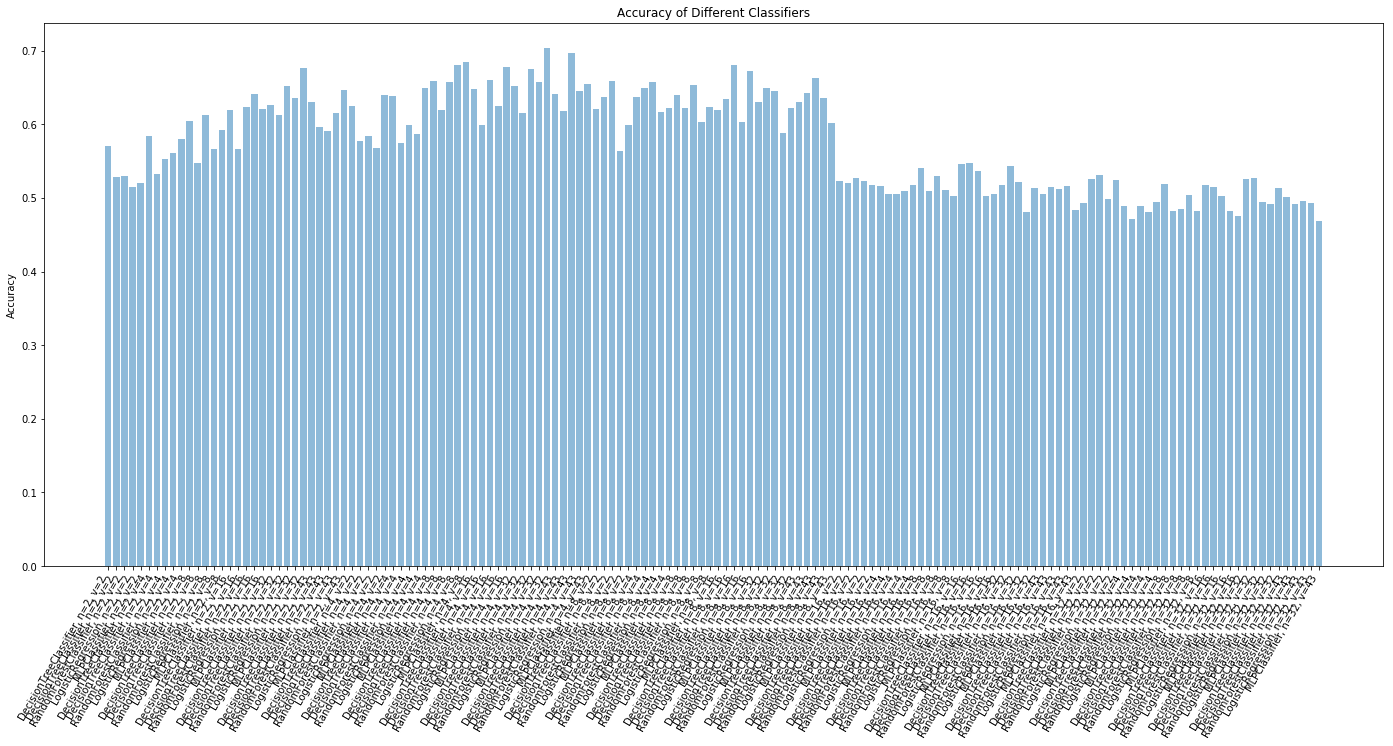

In [16]:
fig, ax = plt.subplots(figsize=(24,10))
y_pos = np.arange(len(classifier))
performance = [float(x) for x in accuracy]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, classifier)
ax.set_xticklabels(classifier, rotation=60, ha="right")
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifiers')
plt.show()

### Stop Spark

In [17]:
spark.stop()